In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"isaac000o","key":"2c1a236c98c03c0ce703259671092452"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/parkinsons-drawings

 87% 36.0M/41.4M [00:01<00:00, 19.5MB/s]
100% 41.4M/41.4M [00:01<00:00, 33.0MB/s]


In [ ]:
from zipfile import ZipFile
filename = "parkinsons-drawings.zip"

with ZipFile(filename,'r') as zip:
  print("Extracting of the file ...")
  zip.extractall()
  print("Done")

Extracting of the file ...
Done


In [ ]:
from imutils import paths
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf




In [ ]:
Training_images_paths = list(paths.list_images("/content/drawings/wave/training"))

i = 0 
Training_labels = []
Training_images = []

while i < len(Training_images_paths):
  Training_label = Training_images_paths[i].split("/")[5]
  Training_labels.append(Training_label)
  Training_image = cv2.imread(Training_images_paths[i])
  Training_image = cv2.resize(Training_image,(256,256))
  Training_images.append(Training_image)
  i = i + 1



Training_images_np = np.array(Training_images) 
Training_labels_np = np.array(Training_labels)



In [ ]:
Testing_images_paths = list(paths.list_images("/content/drawings/wave/testing"))
n = 0
Testing_labels = []
Testing_images = []

while n < len(Testing_images_paths):
  Testing_label = Testing_images_paths[n].split("/")[5]
  Testing_labels.append(Testing_label)
  Testing_image = cv2.imread(Testing_images_paths[n])
  Testing_image = cv2.resize(Testing_image,(256,256))
  Testing_images.append(Testing_image)
  n = n + 1

Testing_images_np = np.array(Testing_images) 
Testing_labels_np = np.array(Testing_labels)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rotation_range=360, 
                                    width_shift_range=0.0, 
                                    height_shift_range=0.0, 
                                    horizontal_flip=True, 
                                    vertical_flip=True)

In [ ]:
aug_traning_images = []
aug_traning_labels = []
v = 0 


while v < len(Training_labels):
  traning_image = Training_images_np[v]
  traning_image = traning_image.reshape((1,)+traning_image.shape)
  it = data_generator.flow(traning_image,batch_size=1,shuffle=True)

  for i in range(210):
    batch = it.next()
    aug_traning_image = batch[0].astype('uint8') 
    aug_traning_images.append(aug_traning_image)
    aug_traning_labels.append(Training_labels[v])
  v = v+1



Training_images = Training_images + aug_traning_images
Training_labels = Training_labels + aug_traning_labels


In [ ]:
aug_testing_images = []
aug_testing_labels = []
x = 0 
while x < len(Testing_labels):
  testing_image = Testing_images_np[x]
  testing_image = testing_image.reshape((1,)+testing_image.shape)
  it = data_generator.flow(testing_image,batch_size=1,shuffle=True)

  for i in range(70):
    batch = it.next()
    aug_testing_image = batch[0].astype('uint8') 
    aug_testing_images.append(aug_testing_image)
    aug_testing_labels.append(Testing_labels[x])
  x = x+1

Testing_images = Testing_images + aug_testing_images
Testing_labels = Testing_labels + aug_testing_labels

In [ ]:
print(len(Testing_images))
print(len(Testing_labels))
print(len(Training_images))
print(len(Training_labels))

2130
2130
15192
15192


<class 'list'>
<class 'numpy.ndarray'>
(15192,)
(2130,)


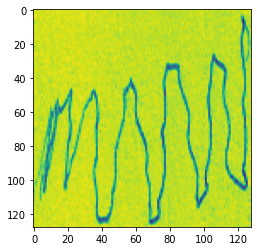

In [ ]:
from matplotlib import pyplot as plt


i = 0 
while i <len(Training_images):
  image = Training_images[i]
  image = cv2.resize(image,(128,128))
  image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  plt.imshow(image)
  Training_images[i] = image
  i = i + 1
  


n = 0 
while n < len(Testing_images):
  image = Testing_images[n]
  image = cv2.resize(image,(128,128))
  image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  Testing_images[n] = image
  n = n + 1

print(type(Training_images))
Training_images = np.array(Training_images)
Testing_images = np.array(Testing_images)
print(type(Training_images))


Training_images = Training_images/255.00
Testing_images = Testing_images/255.00

label_encoder = LabelEncoder()

Training_labels = label_encoder.fit_transform(Training_labels)
print(Training_labels.shape)

label_encoder = LabelEncoder()
Testing_labels = label_encoder.fit_transform(Testing_labels)
print(Testing_labels.shape)



In [ ]:
Training_labels = to_categorical(Training_labels)
Testing_labels = to_categorical(Testing_labels)
import matplotlib.pyplot as plt
print(Training_images[1].shape)

Training_images = np.expand_dims(Training_images, axis=-1)
Testing_images = np.expand_dims(Testing_images, axis=-1)


print(Training_images[1].shape)



print(Training_images.shape)
print(Training_labels.shape)
print(Testing_images.shape)
print(Testing_labels.shape)

(128, 128)
(128, 128, 1)
(15192, 128, 128, 1)
(15192, 2)
(2130, 128, 128, 1)
(2130, 2)


In [ ]:



def parkinson_disease_L2regularizer(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu',  kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

model_L2regularizer= parkinson_disease_L2regularizer(input_shape=(128, 128, 1))
model_L2regularizer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 32)        

In [48]:
hist_L2regularizer = model_L2regularizer.fit(Training_images, Training_labels, batch_size=128, epochs=50, validation_data=(Testing_images, Testing_labels))


Epoch 1/50
119/119 [==============================] - 21s 95ms/step - loss: 0.8419 - accuracy: 0.5437 - val_loss: 0.8303 - val_accuracy: 0.4948
Epoch 2/50
119/119 [==============================] - 10s 86ms/step - loss: 0.8160 - accuracy: 0.5929 - val_loss: 0.8099 - val_accuracy: 0.4925
Epoch 3/50
119/119 [==============================] - 10s 86ms/step - loss: 0.7847 - accuracy: 0.6170 - val_loss: 0.8095 - val_accuracy: 0.4925
Epoch 4/50
119/119 [==============================] - 10s 87ms/step - loss: 0.7462 - accuracy: 0.6282 - val_loss: 0.8313 - val_accuracy: 0.4822
Epoch 5/50
119/119 [==============================] - 10s 87ms/step - loss: 0.7223 - accuracy: 0.6375 - val_loss: 0.8042 - val_accuracy: 0.5437
Epoch 6/50
119/119 [==============================] - 10s 87ms/step - loss: 0.7066 - accuracy: 0.6451 - val_loss: 0.8041 - val_accuracy: 0.5531
Epoch 7/50
119/119 [==============================] - 10s 87ms/step - loss: 0.6945 - accuracy: 0.6455 - val_loss: 0.8079 - val_accuracy:

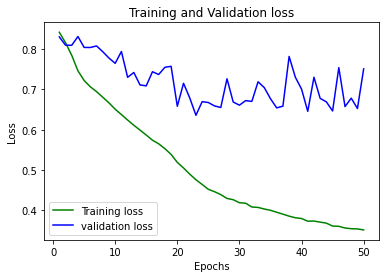

In [49]:
import matplotlib.pyplot as plt

loss_train = hist_L2regularizer.history['loss']
loss_val = hist_L2regularizer.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

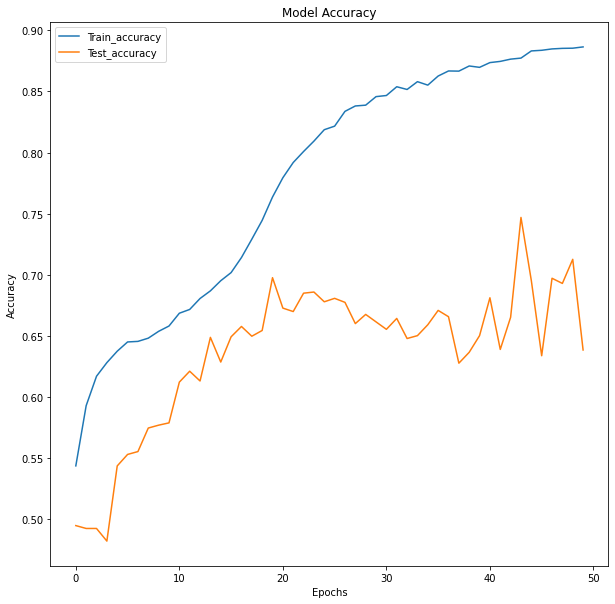

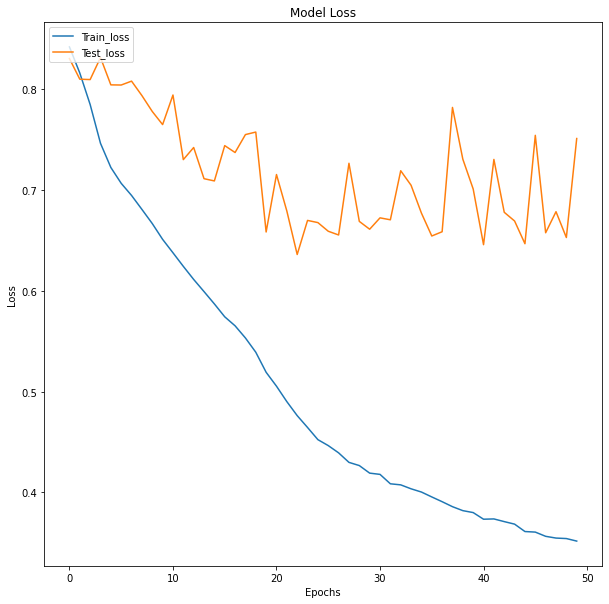

In [50]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 10))
plt.plot(hist_L2regularizer.history['accuracy'], label='Train_accuracy')
plt.plot(hist_L2regularizer.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist_L2regularizer.history['loss'], label='Train_loss')
plt.plot(hist_L2regularizer.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [51]:
from sklearn.metrics import classification_report

ypred = model_L2regularizer.predict(Testing_images)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(Testing_labels, axis=1)
print(classification_report(y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60      1065
           1       0.62      0.73      0.67      1065

    accuracy                           0.64      2130
   macro avg       0.64      0.64      0.64      2130
weighted avg       0.64      0.64      0.64      2130



In [52]:
def parkinson_disease_Dropout(input_shape=(128, 128, 1)):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu'))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))
    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu'))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu'))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu'))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))    
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [53]:
model_dropout= parkinson_disease_Dropout(input_shape=(128, 128, 1))
model_dropout.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 40, 40, 128)      0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 4, 4, 32)        

In [54]:
hist_dropout = model_dropout.fit(Training_images, Training_labels, batch_size=128, epochs=50, validation_data=(Testing_images, Testing_labels))


Epoch 1/50
119/119 [==============================] - 12s 87ms/step - loss: 0.6935 - accuracy: 0.5051 - val_loss: 0.6930 - val_accuracy: 0.5047
Epoch 2/50
119/119 [==============================] - 10s 86ms/step - loss: 0.6916 - accuracy: 0.5209 - val_loss: 0.6922 - val_accuracy: 0.5038
Epoch 3/50
119/119 [==============================] - 10s 86ms/step - loss: 0.6857 - accuracy: 0.5497 - val_loss: 0.6874 - val_accuracy: 0.5324
Epoch 4/50
119/119 [==============================] - 10s 86ms/step - loss: 0.6735 - accuracy: 0.5820 - val_loss: 0.6891 - val_accuracy: 0.5136
Epoch 5/50
119/119 [==============================] - 10s 86ms/step - loss: 0.6625 - accuracy: 0.6012 - val_loss: 0.6953 - val_accuracy: 0.5239
Epoch 6/50
119/119 [==============================] - 10s 86ms/step - loss: 0.6530 - accuracy: 0.6085 - val_loss: 0.7222 - val_accuracy: 0.5263
Epoch 7/50
119/119 [==============================] - 10s 86ms/step - loss: 0.6490 - accuracy: 0.6178 - val_loss: 0.7288 - val_accuracy:

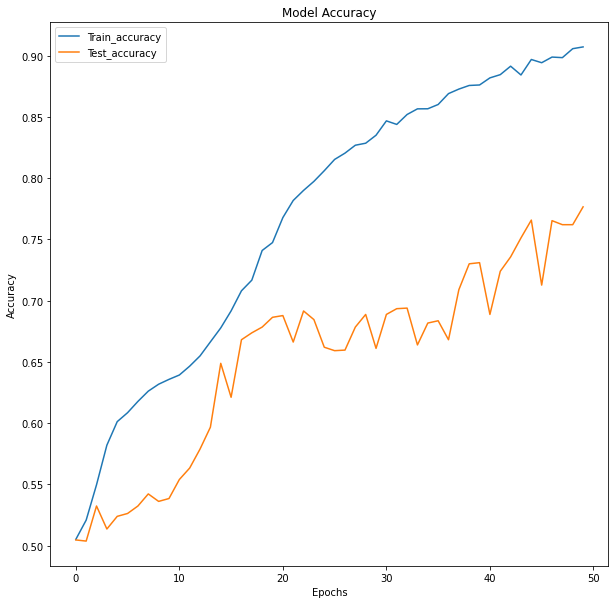

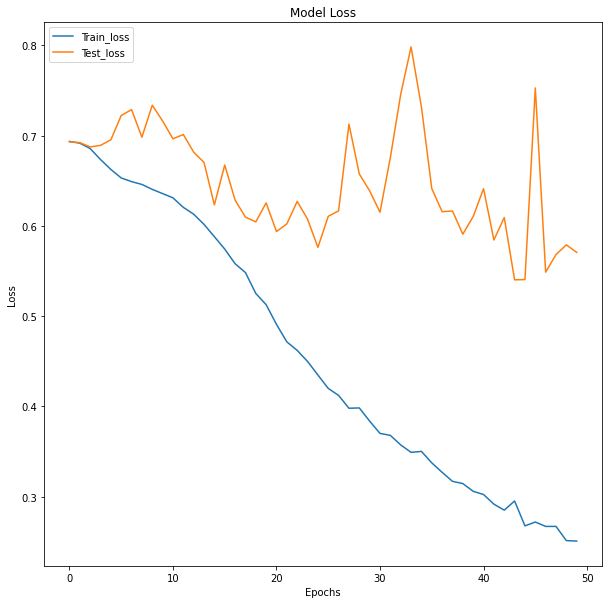

In [55]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist_dropout.history['accuracy'], label='Train_accuracy')
plt.plot(hist_dropout.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist_dropout.history['loss'], label='Train_loss')
plt.plot(hist_dropout.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [56]:
ypred = model_dropout.predict(Testing_images)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(Testing_labels, axis=1)
print(classification_report(y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1065
           1       0.78      0.77      0.77      1065

    accuracy                           0.78      2130
   macro avg       0.78      0.78      0.78      2130
weighted avg       0.78      0.78      0.78      2130



In [57]:

from keras.constraints import unit_norm
def parkinson_disease_weight_constraints(input_shape=(128, 128, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu', kernel_constraint=unit_norm()))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu', kernel_constraint=unit_norm()))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', kernel_constraint=unit_norm()))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', kernel_constraint=unit_norm()))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [58]:
model_weight_constraints= parkinson_disease_weight_constraints(input_shape=(128, 128, 1))
model_weight_constraints.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 32)        

In [59]:
hist_weight_constraints = model_weight_constraints.fit(Training_images, Training_labels, batch_size=128, epochs=50, validation_data=(Testing_images, Testing_labels))

Epoch 1/50
119/119 [==============================] - 11s 89ms/step - loss: 234.9532 - accuracy: 0.5142 - val_loss: 35.9784 - val_accuracy: 0.4869
Epoch 2/50
119/119 [==============================] - 10s 86ms/step - loss: 27.2421 - accuracy: 0.5550 - val_loss: 30.7121 - val_accuracy: 0.5169
Epoch 3/50
119/119 [==============================] - 10s 86ms/step - loss: 22.7140 - accuracy: 0.5747 - val_loss: 25.7794 - val_accuracy: 0.5423
Epoch 4/50
119/119 [==============================] - 10s 86ms/step - loss: 19.9295 - accuracy: 0.5769 - val_loss: 23.4810 - val_accuracy: 0.5624
Epoch 5/50
119/119 [==============================] - 10s 86ms/step - loss: 18.2064 - accuracy: 0.5762 - val_loss: 22.0849 - val_accuracy: 0.5704
Epoch 6/50
119/119 [==============================] - 10s 86ms/step - loss: 17.0319 - accuracy: 0.5820 - val_loss: 21.6075 - val_accuracy: 0.5723
Epoch 7/50
119/119 [==============================] - 10s 86ms/step - loss: 16.0388 - accuracy: 0.5862 - val_loss: 21.2135 

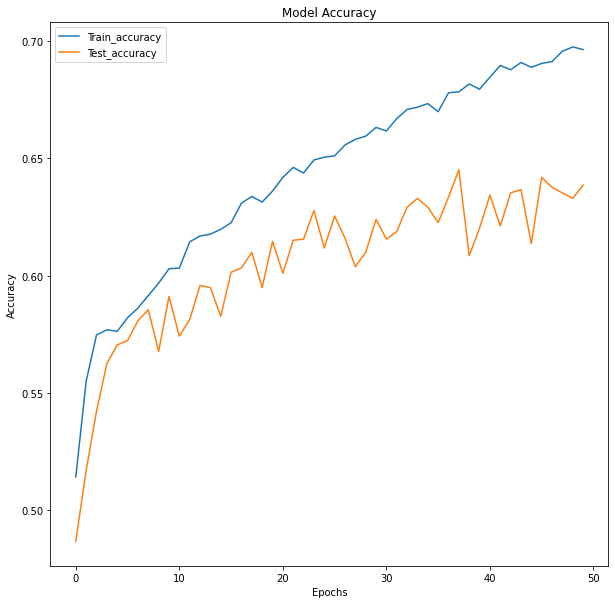

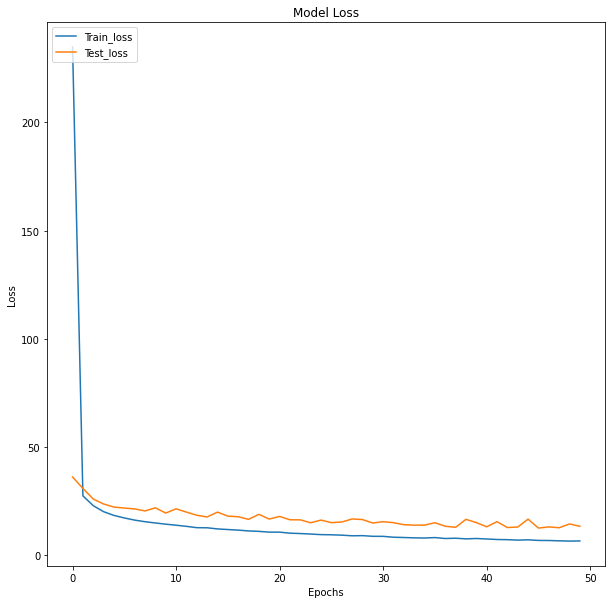

In [60]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist_weight_constraints.history['accuracy'], label='Train_accuracy')
plt.plot(hist_weight_constraints.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist_weight_constraints.history['loss'], label='Train_loss')
plt.plot(hist_weight_constraints.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [61]:
ypred = model_weight_constraints.predict(Testing_images)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(Testing_labels, axis=1)
print(classification_report(y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.69      0.50      0.58      1065
           1       0.61      0.77      0.68      1065

    accuracy                           0.64      2130
   macro avg       0.65      0.64      0.63      2130
weighted avg       0.65      0.64      0.63      2130



In [62]:
def parkinson_disease_Weight_Initialization(input_shape=(128, 128, 1)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer='he_normal'))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer='he_normal'))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer='he_normal'))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                   kernel_initializer='he_normal'))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [63]:
model_Weight_Initialization = parkinson_disease_Weight_Initialization(input_shape=(128, 128, 1))
model_Weight_Initialization.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                            
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 4, 4, 32)        

In [64]:
hist_Weight_Initialization = model_Weight_Initialization.fit(Training_images, Training_labels, batch_size=128, epochs=50, validation_data=(Testing_images, Testing_labels))

Epoch 1/50
119/119 [==============================] - 11s 88ms/step - loss: 0.6990 - accuracy: 0.5577 - val_loss: 0.6897 - val_accuracy: 0.5033
Epoch 2/50
119/119 [==============================] - 10s 85ms/step - loss: 0.6434 - accuracy: 0.6253 - val_loss: 0.7155 - val_accuracy: 0.4930
Epoch 3/50
119/119 [==============================] - 10s 86ms/step - loss: 0.6175 - accuracy: 0.6403 - val_loss: 0.6725 - val_accuracy: 0.6136
Epoch 4/50
119/119 [==============================] - 10s 86ms/step - loss: 0.5937 - accuracy: 0.6602 - val_loss: 0.6811 - val_accuracy: 0.6117
Epoch 5/50
119/119 [==============================] - 10s 86ms/step - loss: 0.5751 - accuracy: 0.6738 - val_loss: 0.6613 - val_accuracy: 0.6343
Epoch 6/50
119/119 [==============================] - 10s 86ms/step - loss: 0.5566 - accuracy: 0.6837 - val_loss: 0.6446 - val_accuracy: 0.6531
Epoch 7/50
119/119 [==============================] - 10s 86ms/step - loss: 0.5404 - accuracy: 0.6921 - val_loss: 0.6541 - val_accuracy:

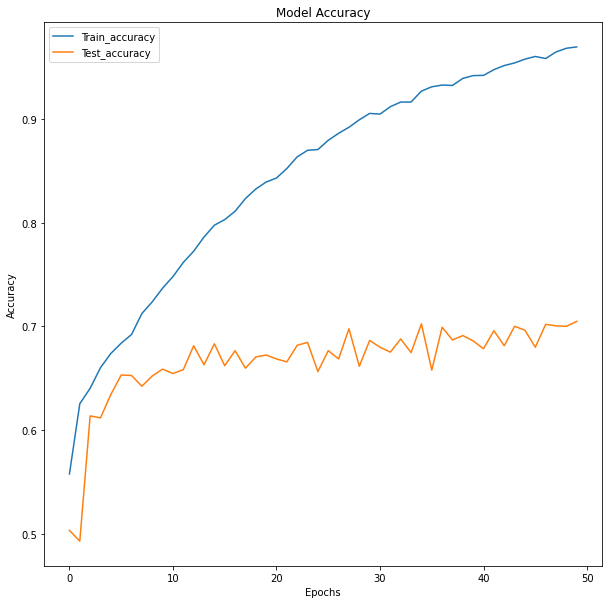

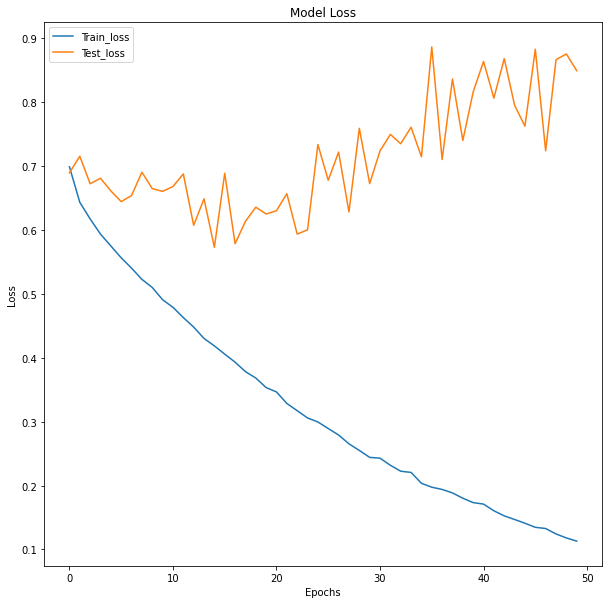

In [65]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist_Weight_Initialization.history['accuracy'], label='Train_accuracy')
plt.plot(hist_Weight_Initialization.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist_Weight_Initialization.history['loss'], label='Train_loss')
plt.plot(hist_Weight_Initialization.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [66]:
ypred = model_Weight_Initialization.predict(Testing_images)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(Testing_labels, axis=1)
print(classification_report(y_test_pred, ypred))

              precision    recall  f1-score   support

           0       0.74      0.64      0.68      1065
           1       0.68      0.77      0.72      1065

    accuracy                           0.70      2130
   macro avg       0.71      0.70      0.70      2130
weighted avg       0.71      0.70      0.70      2130



In [67]:
def plot_graph (brain_history_C):
  acc = brain_history_C.history['accuracy']
  val_acc = brain_history_C.history['val_accuracy']
  loss = brain_history_C.history['loss']
  val_loss = brain_history_C.history['val_loss']

  epochs_range = range(50)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()



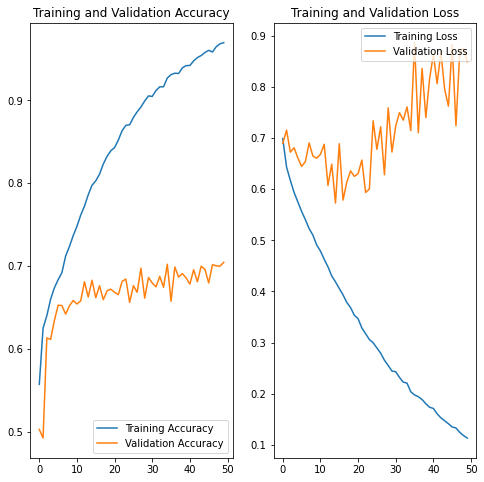

In [68]:
plot_graph(hist_Weight_Initialization)

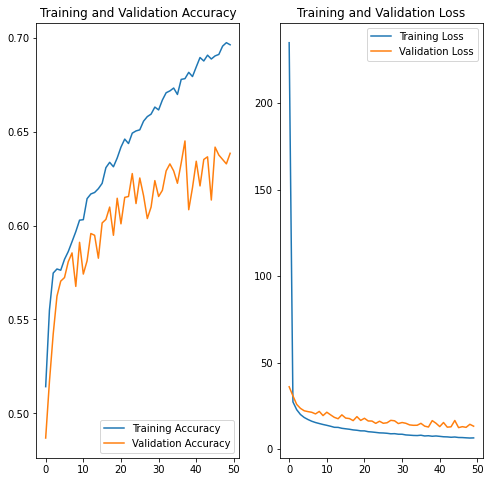

In [69]:
plot_graph(hist_weight_constraints)

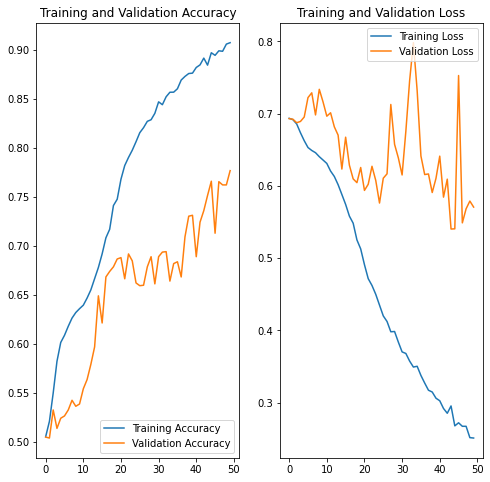

In [70]:
plot_graph(hist_dropout)

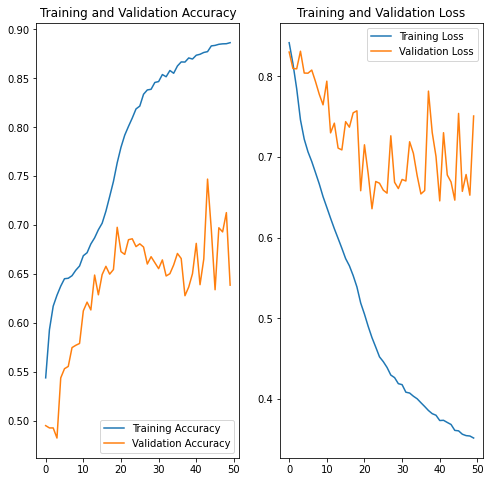

In [71]:
plot_graph(hist_L2regularizer)